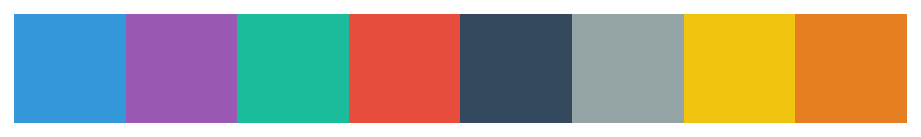

In [1]:
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
# plt.style.use("seaborn-poster") ### Use this for figures used in posters
plt.style.use("seaborn-paper") ### Use this for figures used in paper
# plt.style.use("seaborn-talk") ### Use this for figures used in presentations/talks
from sargan_models import SARGAN
import tensorflow as tf
import numpy as np
import time
import sys, os
from tqdm import tqdm
from sar_utilities import to_dB, visualize_raw_data, get_spectrum, \
    visualize_raw_data_spectrum, insert_freq_gaps, \
    generate_raw_data_from_dict, downsample, snr, \
    add_gaussian_noise, preprocess_train, preprocess_test, \
    generate_raw_data, get_frequency_parameters, get_frequency_gap_indices
from sargan_config import Config as conf
import math
from alert_utilities import send_images_via_email
import scipy.io as sio
from chart_utilities import config_figures, color_palette

config_figures(mpl, color_palette)

%matplotlib inline
%config InlineBackend.figure_format = "retina"


import seaborn as sns

sns.palplot(color_palette)
sns.set_context("paper")


ori_color = color_palette[0]
corrupted_color = color_palette[1]
reconstructed_color = color_palette[2]
omp_color = color_palette[7]

from sar_data_utilities import DATA_PATH, load_data_dict, load_deterministic_scene_data

scene_type = "uniform"
# Get scene data
scene_raw_data_mat, scene_image, n_samples, n_apertures, sampling_period = load_deterministic_scene_data(scene_type)
scene_raw_data_batch = np.expand_dims(scene_raw_data_mat, axis=0)

# Get SAR dictionary data
dict_type = "20"
dict_filename, sar_dict_mat, n_samples, n_apertures, n_atoms, transmitted_pulse, transmitted_pulse_sampling_period = load_data_dict(dict_type=dict_type)
processed_transmitted_pulse = np.concatenate((transmitted_pulse, np.zeros((900, 1))))

# Get frequency parameters
n_fft, sampling_freq, df, freq = get_frequency_parameters(n_samples, sampling_period)

# Get frequency gaps
from sar_data_utilities import freq_band
missing_rates = np.asarray([0.5, 0.6])
n_missing_rates = missing_rates.shape[0]
freq_gaps = get_frequency_gap_indices(freq_band, df, missing_rates)

img_size = (n_samples, n_apertures)
batch_size = conf.batch_size

model_trained_epoch = 159
model_path_test = os.path.join(DATA_PATH, "radarconf19_v3/trained_models/checkpoint/", "sar_dict_target_distance_{}_5_freq_corrupted_real_det_0_1_coef_range_dict_dist_{}_model_{}.ckpt".format(dict_type, dict_type, model_trained_epoch))
fig_output_path = os.path.join(DATA_PATH, "radarconf19_paper/22074730sjjkfjywrsmx")
data_output_path = os.path.join(DATA_PATH, "radarconf19_v4/outputs")
SAVE_FIGS = False

In [ ]:
def run_omp_recovery(corrupted_data, pulse, freq_gap, n_nonzero_coefs):
    from sklearn.linear_model import OrthogonalMatchingPursuit
    from scipy.linalg import circulant
    
    D = circulant(pulse)
    D_batch = np.expand_dims(D, axis=0)
    D_gap, _ = insert_freq_gaps(D_batch, D.shape, freq_gap)
    D_gap = D_gap[0, :, :]

    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
    omp.fit(D_gap, corrupted_data)
    coef = omp.coef_
    omp_reconstructed = np.transpose(np.dot(coef, D))
    return omp_reconstructed

In [ ]:
model = SARGAN(img_size, batch_size)
d_opt = tf.train.AdamOptimizer(learning_rate=conf.learning_rate).minimize(model.d_loss, var_list=model.d_vars)
g_opt = tf.train.AdamOptimizer(learning_rate=conf.learning_rate).minimize(model.g_loss, var_list=model.g_vars)

saver = tf.train.Saver()

start_time = time.time()
# GPU options
gpu = "3"
gpu_options = tf.GPUOptions(allow_growth=True, visible_device_list=gpu)
config=tf.ConfigProto(gpu_options=gpu_options)
pbar = tqdm(range(n_missing_rates), unit="missing rate")
scene_matfile_dict = {}
corrupted = []
sargan_rec = []
omp_rec = []
with tf.Session(config=config) as sess:

    saver.restore(sess, model_path_test)
    img = scene_raw_data_batch
    cond = img.copy()
    for i_missing_rate in pbar:
        
        freq_gap = freq_gaps[i_missing_rate]
        pcond, _ = insert_freq_gaps(cond, (n_samples, n_apertures), freq_gap)
        pimg, pcond = preprocess_test(img, pcond, (n_samples, n_apertures))

        # Recovery using SARGAN
        gen_img = sess.run(model.gen_img, feed_dict={model.image:pimg, model.cond:pcond})
        in_snr, sargan_out_snr, sargan_snr_gain = snr(pimg, pcond, gen_img, norm_flag=1, mag_flag=0)

        # Recovery using OMP
        omp_reconstructed = run_omp_recovery(cond[0, :, :], processed_transmitted_pulse, freq_gap, n_nonzero_coefs=100)
        omp_reconstructed = np.roll(omp_reconstructed, 300, axis=0)
        _, omp_out_snr, omp_snr_gain = snr(pimg[0, :, :, 0], pcond[0, :, :, 0], omp_reconstructed, norm_flag=1, mag_flag=0)
        
        corrupted.append(pcond[0, :, :, 0])
        sargan_rec.append(gen_img[0, :, :, 0])
        omp_rec.append(omp_reconstructed)

In [4]:
# scene_matfile_dict = {
#     "corrupted": corrupted,
#     "sargan_rec": sargan_rec,
#     "omp_rec": omp_rec,
#     "missing_rates": list(missing_rates)
# }
scene_matfile_path = os.path.join(data_output_path, scene_type + "_dict_" + dict_type + "_scene_rec")
# sio.savemat(scene_matfile_path + ".mat", scene_matfile_dict)
print(scene_matfile_path)

/data/dung/sargan/radarconf19_v4/outputs/uniform_dict_20_scene_rec


In [26]:
float_type = np.float32
img_rec_matfile_path = scene_matfile_path + "_img"
img_rec_data = sio.loadmat("/data/dung/sargan/radarconf19_v4/outputs/uniform_dict_20_scene_rec_img.mat")
I_original = img_rec_data["I_original"].astype(float_type)
I_corrupted = img_rec_data["I_corrupted"].astype(float_type)
I_sargan = img_rec_data["I_sargan"].astype(float_type)
I_omp = img_rec_data["I_omp"].astype(float_type)
corrupted = img_rec_data["corrupted"].astype(float_type)
sargan_rec = img_rec_data["sargan_rec"].astype(float_type)
omp_rec = img_rec_data["omp_rec"].astype(float_type)
original = img_rec_data["original"].astype(float_type)
missing_rates = img_rec_data["missing_rates"].astype(float_type)
n_missing_rates = missing_rates.shape[0]

In [28]:
missing_rates[0]

array([0.7, 0.8], dtype=float32)

TypeError: Invalid dimensions for image data

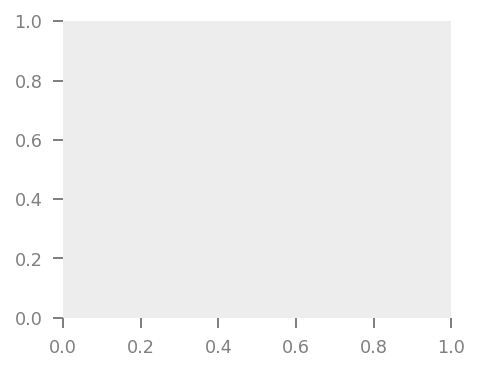

In [11]:
db_range = 50
fig = plt.figure(figsize=(16, 6))

# Original raw data
ax = fig.add_subplot(2, 4, 1)
ax = visualize_raw_data(original, ax, db_range=db_range)

# Corrupted raw data
ax = fig.add_subplot(2, 4, 2)
ax = visualize_raw_data(corrupted, ax, db_range=db_range)

# OMP-recovered raw data
ax = fig.add_subplot(2, 4, 4)
ax = visualize_raw_data(omp_rec, ax, db_range=db_range)

# SARGAN-recovered raw data
ax = fig.add_subplot(2, 4, 3)
ax = visualize_raw_data(sargan_rec, ax, db_range=db_range)

# Original image
ax = fig.add_subplot(2, 4, 5)
ax = visualize_raw_data(scene_image[0:250, 50:450], ax, db_range=db_range)

# Corrupted image
ax = fig.add_subplot(2, 4, 6)
ax = visualize_raw_data(I_corrupted[0:250, 50:450], ax, db_range=db_range)

# OMP-recovered image
ax = fig.add_subplot(2, 4, 7)
ax = visualize_raw_data(I_omp[0:250, 50:450], ax, db_range=db_range)

# SARGAN-recovered image
ax = fig.add_subplot(2, 4, 8)
ax = visualize_raw_data(I_sargan[0:250, 50:450], ax, db_range=db_range)

plt.tight_layout()

if SAVE_FIGS:
    recovery_filename = scene_type + "_scene_0_8_missing_sargan_omp_image_raw.jpg"
    plt.savefig(os.path.join(output_path, recovery_filename), dpi=300)

In [ ]:
fig = plt.figure(figsize=(20, 3))

# Time domain - one aperture
i_aperture = 0; lw = 1.5
ax = fig.add_subplot(141)
ax.plot(pimg[0, :, i_aperture, 0], color=ori_color, lw=lw, label="Original")
ax.plot(pcond[0, :, i_aperture, 0], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(gen_img[0, :, i_aperture, 0], color=reconstructed_color, lw=lw, label="Recovered by SARGAN")
ax.set_xlim([0, n_samples])
ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

ax = fig.add_subplot(142)
ax.plot(pimg[0, :, i_aperture, 0], color=ori_color, lw=lw, label="Original")
ax.plot(pcond[0, :, i_aperture, 0], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(omp_reconstructed[:, i_aperture], color=omp_color, lw=lw, label="Recovered by OMP")
ax.set_xlim([0, n_samples])
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')
ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")

ori_spectrum = get_spectrum(pimg[0, :, i_aperture, 0], n_fft); ori_spectrum_dB = to_dB(ori_spectrum)
corrupted_spectrum = get_spectrum(pcond[0, :, i_aperture, 0], n_fft); corrupted_spectrum_dB = to_dB(corrupted_spectrum)
corrupted_spectrum_dB[corrupted_spectrum_dB < -200] = -50
sargan_spectrum = get_spectrum(gen_img[0, :, i_aperture, 0], n_fft); sargan_spectrum_dB = to_dB(sargan_spectrum)
omp_spectrum = get_spectrum(omp_reconstructed[:, i_aperture], n_fft); omp_spectrum_dB = to_dB(omp_spectrum)
zoom_factor = 8
x_range = [0.2, 3]; y_min = 20
ax = fig.add_subplot(143)
ax.plot(freq[0:n_fft // zoom_factor], ori_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=lw, label="Original")
ax.plot(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(freq[0:n_fft // zoom_factor], sargan_spectrum_dB[0:n_fft//zoom_factor], color=reconstructed_color, lw=lw, label="Recovered by SARGAN")
ax.fill_between(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], y_min, color=corrupted_color, alpha=0.1)
ax.set_ylim(ymin=y_min); ax.set_xlim(x_range)
# ax.set_title("Spectrum: deterministic scene", color="gray")
ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

ax = fig.add_subplot(144)
ax.plot(freq[0:n_fft // zoom_factor], ori_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=lw, label="Original")
ax.plot(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], color=corrupted_color, lw=lw, label="Corrupted")
ax.plot(freq[0:n_fft // zoom_factor], omp_spectrum_dB[0:n_fft//zoom_factor], color=omp_color, lw=lw, label="Recovered by OMP")
ax.fill_between(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], y_min, color=corrupted_color, alpha=0.1)
ax.set_ylim(ymin=y_min); ax.set_xlim(x_range)
# # ax.set_title("Spectrum: deterministic scene", color="gray")
ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

plt.tight_layout()

if SAVE_FIGS:
    recovery_filename = scene_type + "_scene_0_8_missing_sargan_omp_one_aperture.jpg"
    plt.savefig(os.path.join(output_path, recovery_filename), dpi=300)

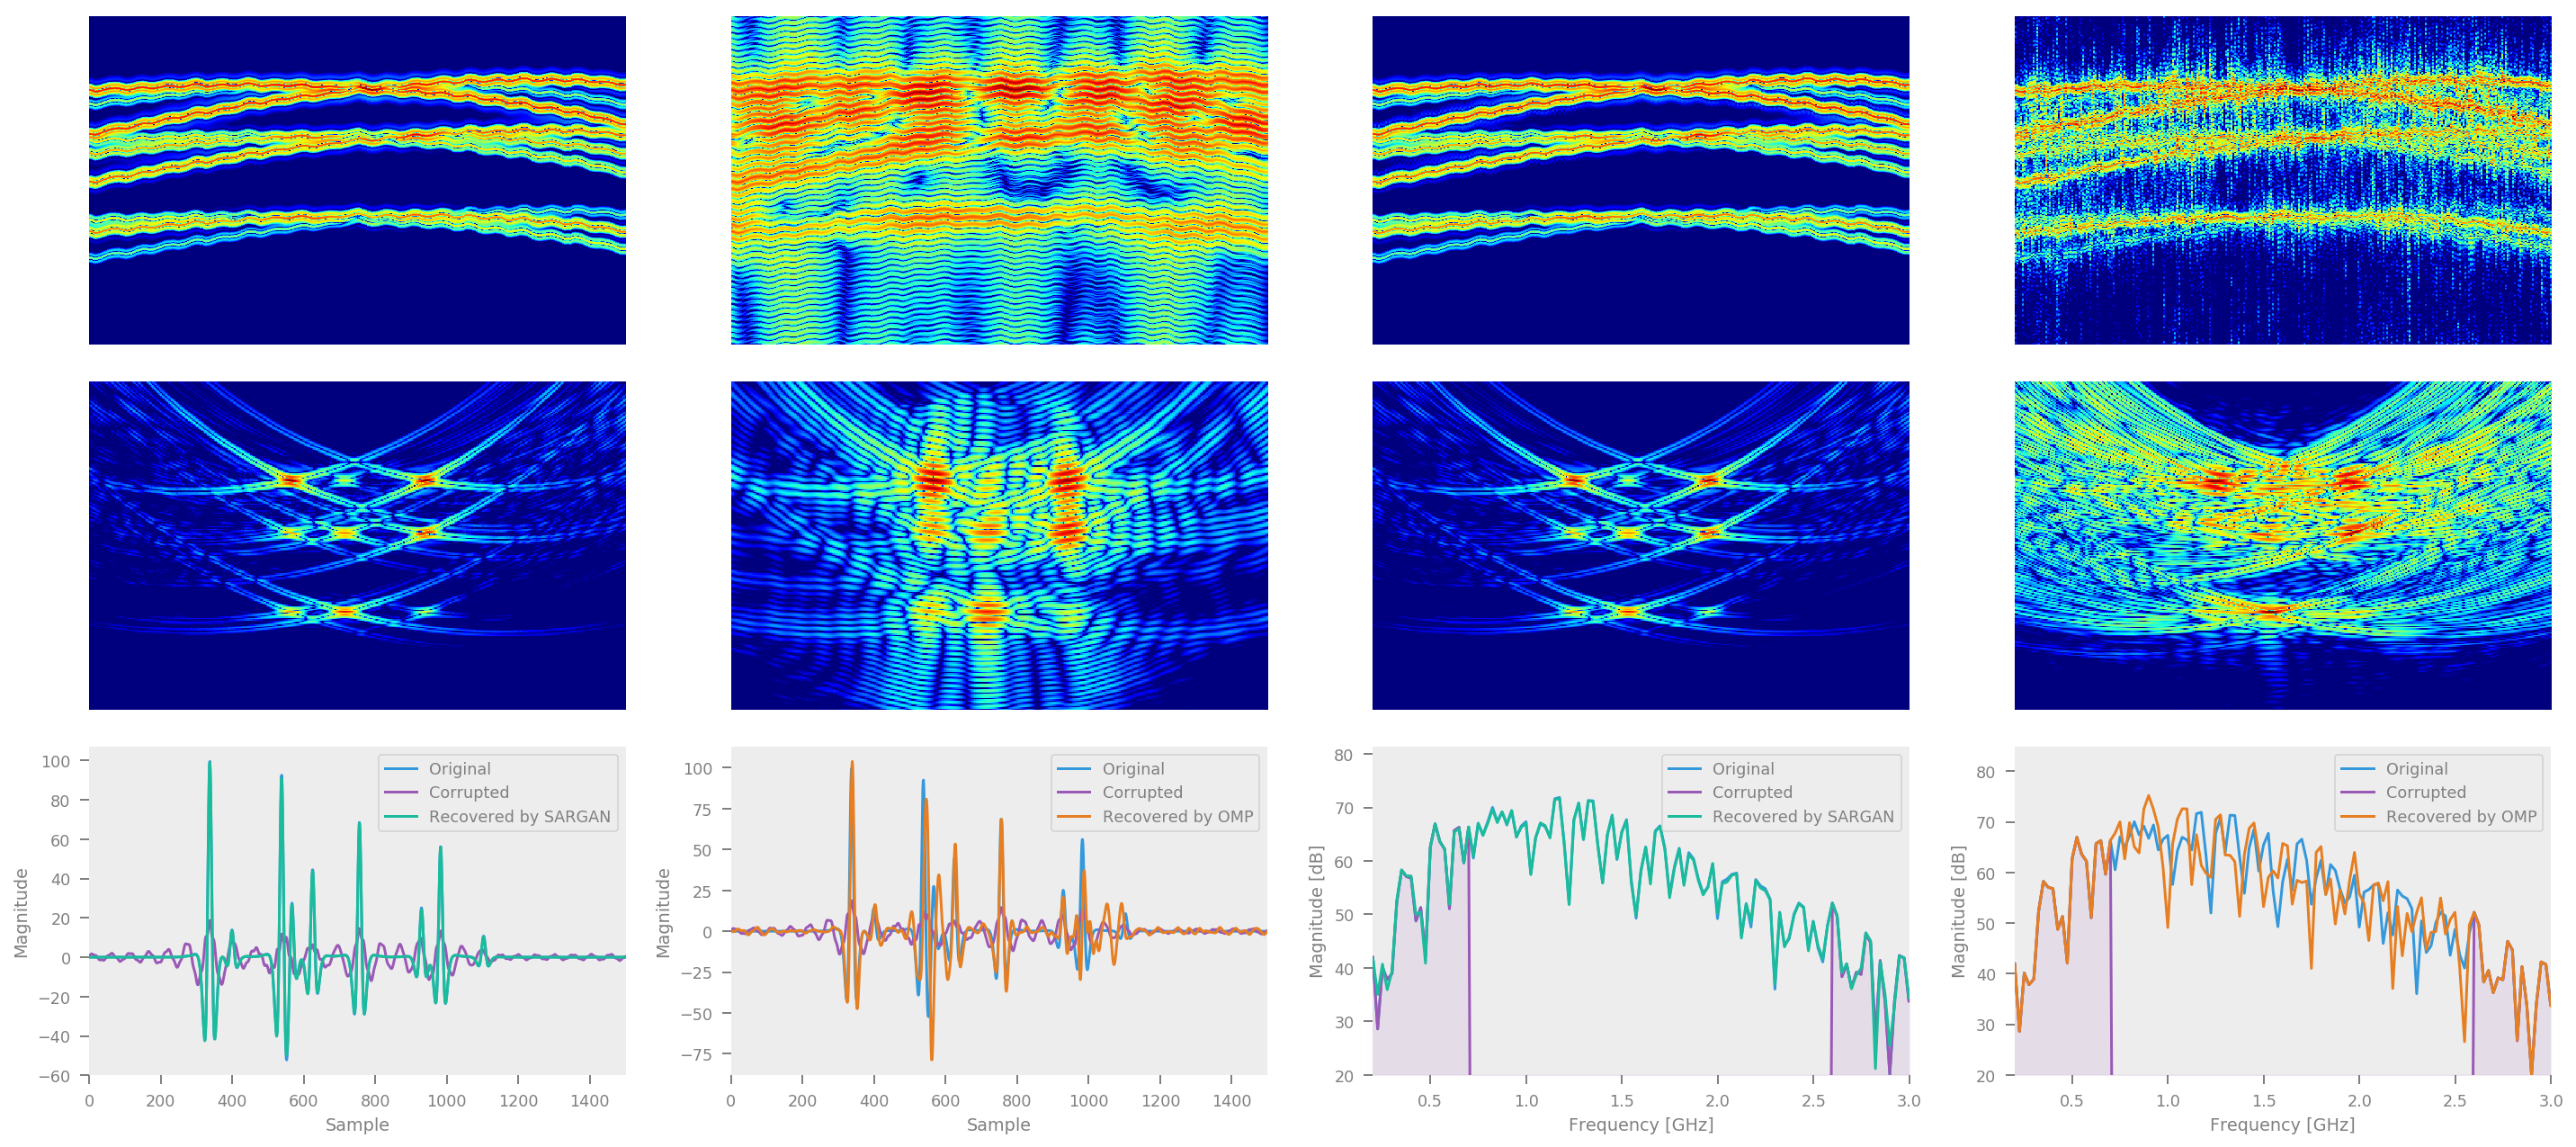

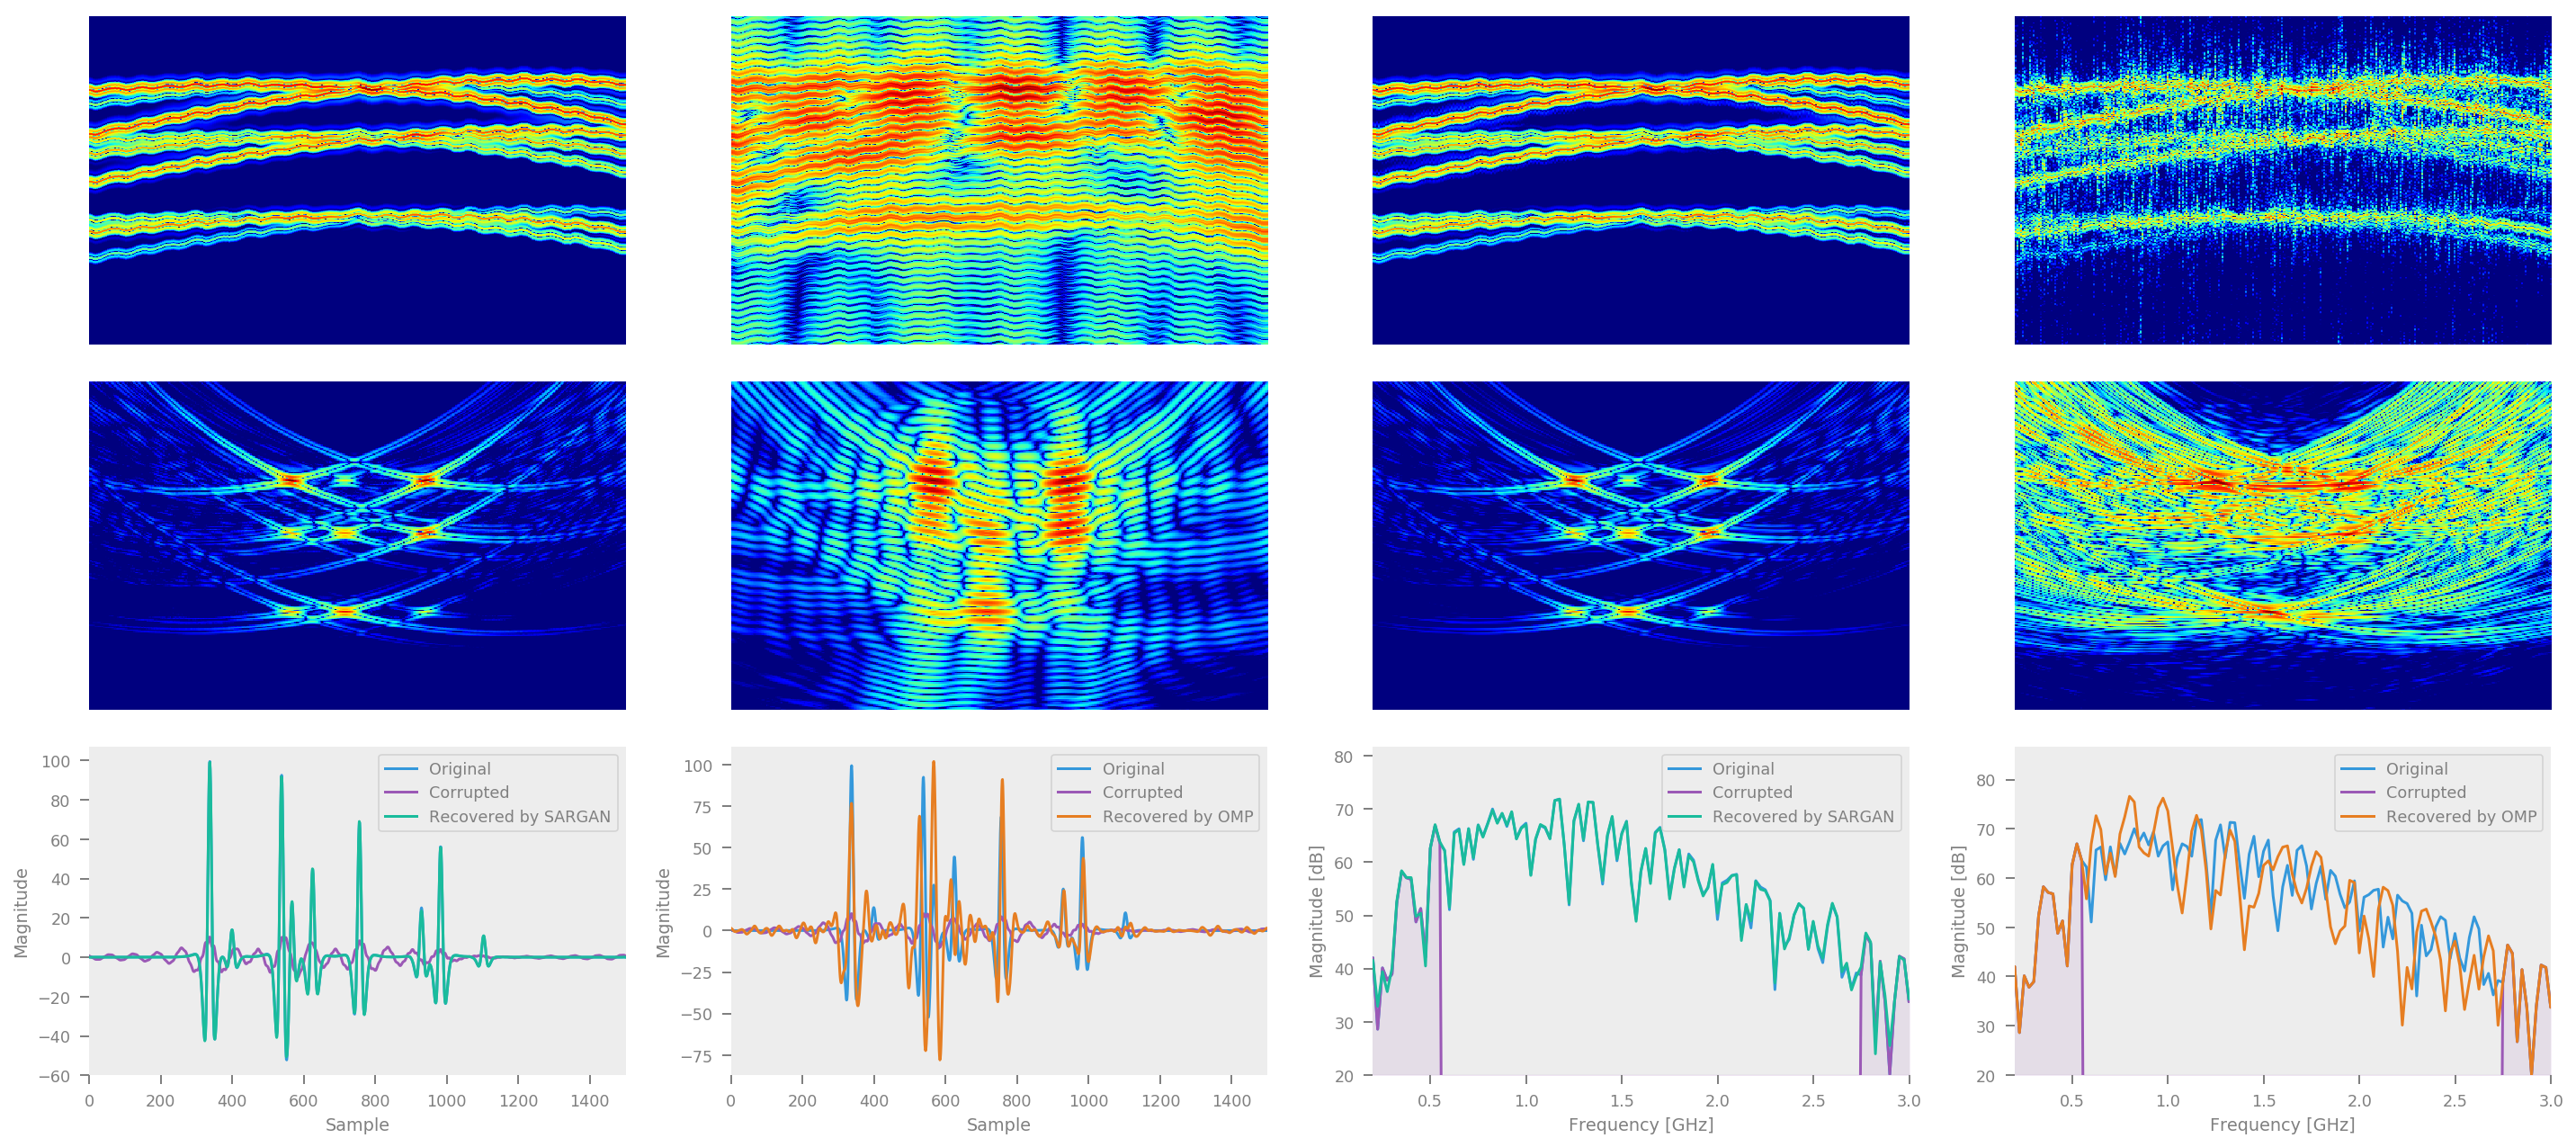

In [23]:
db_range = 50
for i_missing_rate in range(n_missing_rates):
    fig = plt.figure(figsize=(20, 9))
    
    missing_rate = missing_rates[i_missing_rate]
    missing_rate_str = "{:.0f}".format(missing_rate*100)
    corrupted_i = corrupted[i_missing_rate]
    sargan_rec_i = sargan_rec[i_missing_rate]
    omp_rec_i = omp_rec[i_missing_rate]
    I_corrupted_i = I_corrupted[i_missing_rate]
    I_sargan_i = I_sargan[i_missing_rate]
    I_omp_i = I_omp[i_missing_rate]
    
    # Original raw data
    ax = fig.add_subplot(3, 4, 1)
    ax = visualize_raw_data(original, ax, db_range=db_range)

    # Corrupted raw data
    ax = fig.add_subplot(3, 4, 2)
    ax = visualize_raw_data(corrupted_i, ax, db_range=db_range)

    # SARGAN-recovered raw data
    ax = fig.add_subplot(3, 4, 3)
    ax = visualize_raw_data(sargan_rec_i, ax, db_range=db_range)

    # OMP-recovered raw data
    ax = fig.add_subplot(3, 4, 4)
    ax = visualize_raw_data(omp_rec_i, ax, db_range=db_range)

    # Original image
    ax = fig.add_subplot(3, 4, 5)
    ax = visualize_raw_data(I_original[0:250, 50:450], ax, db_range=db_range)

    # Corrupted image
    ax = fig.add_subplot(3, 4, 6)
    ax = visualize_raw_data(I_corrupted_i[0:250, 50:450], ax, db_range=db_range)

    # SARGAN-recovered image
    ax = fig.add_subplot(3, 4, 7)
    ax = visualize_raw_data(I_sargan_i[0:250, 50:450], ax, db_range=db_range)

    # OMP-recovered image
    ax = fig.add_subplot(3, 4, 8)
    ax = visualize_raw_data(I_omp_i[0:250, 50:450], ax, db_range=db_range)

    # Time domain - one aperture
    i_aperture = 0; lw = 1.5
    ax = fig.add_subplot(349)
    ax.plot(original[:, i_aperture], color=ori_color, lw=lw, label="Original")
    ax.plot(corrupted_i[:, i_aperture], color=corrupted_color, lw=lw, label="Corrupted")
    ax.plot(sargan_rec_i[:, i_aperture], color=reconstructed_color, lw=lw, label="Recovered by SARGAN")
    ax.set_xlim([0, n_samples])
    ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")
    legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

    ax = fig.add_subplot(3, 4, 10)
    ax.plot(original[:, i_aperture], color=ori_color, lw=lw, label="Original")
    ax.plot(corrupted_i[:, i_aperture], color=corrupted_color, lw=lw, label="Corrupted")
    ax.plot(omp_rec_i[:, i_aperture], color=omp_color, lw=lw, label="Recovered by OMP")
    ax.set_xlim([0, n_samples])
    legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')
    ax.set_xlabel("Sample"); ax.set_ylabel("Magnitude")

    ori_spectrum = get_spectrum(original[:, i_aperture], n_fft); ori_spectrum_dB = to_dB(ori_spectrum)
    corrupted_spectrum = get_spectrum(corrupted_i[:, i_aperture], n_fft); corrupted_spectrum_dB = to_dB(corrupted_spectrum)
    corrupted_spectrum_dB[corrupted_spectrum_dB < -200] = -50
    sargan_spectrum = get_spectrum(sargan_rec_i[:, i_aperture], n_fft); sargan_spectrum_dB = to_dB(sargan_spectrum)
    omp_spectrum = get_spectrum(omp_rec_i[:, i_aperture], n_fft); omp_spectrum_dB = to_dB(omp_spectrum)
    zoom_factor = 8
    x_range = [0.2, 3]; y_min = 20
    ax = fig.add_subplot(3, 4, 11)
    ax.plot(freq[0:n_fft // zoom_factor], ori_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=lw, label="Original")
    ax.plot(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], color=corrupted_color, lw=lw, label="Corrupted")
    ax.plot(freq[0:n_fft // zoom_factor], sargan_spectrum_dB[0:n_fft//zoom_factor], color=reconstructed_color, lw=lw, label="Recovered by SARGAN")
    ax.fill_between(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], y_min, color=corrupted_color, alpha=0.1)
    ax.set_ylim(ymin=y_min); ax.set_xlim(x_range)
    # ax.set_title("Spectrum: deterministic scene", color="gray")
    ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
    legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')

    ax = fig.add_subplot(3, 4, 12)
    ax.plot(freq[0:n_fft // zoom_factor], ori_spectrum_dB[0:n_fft//zoom_factor], color=ori_color, lw=lw, label="Original")
    ax.plot(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], color=corrupted_color, lw=lw, label="Corrupted")
    ax.plot(freq[0:n_fft // zoom_factor], omp_spectrum_dB[0:n_fft//zoom_factor], color=omp_color, lw=lw, label="Recovered by OMP")
    ax.fill_between(freq[0:n_fft // zoom_factor], corrupted_spectrum_dB[0:n_fft//zoom_factor], y_min, color=corrupted_color, alpha=0.1)
    ax.set_ylim(ymin=y_min); ax.set_xlim(x_range)
    # # ax.set_title("Spectrum: deterministic scene", color="gray")
    ax.set_xlabel("Frequency [GHz]"); ax.set_ylabel("Magnitude [dB]")
    legend_handler = ax.legend(); plt.setp(legend_handler.get_texts(), color='gray')
    
    plt.tight_layout()
    if SAVE_FIGS:
        fig_output_path = os.path.join(DATA_PATH, "radarconf19_paper/22074730sjjkfjywrsmx")
        recovery_filename = scene_type + "_dict_" + dict_type + "_" + missing_rate_str + "_missing_sargan_omp_image_raw_one_aperture.jpg"
        plt.savefig(os.path.join(fig_output_path, recovery_filename), dpi=300)